In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import posixpath
import pandas as pd
import wfdb
from wfdb import processing
from scipy.signal import find_peaks,butter, lfilter, freqz
import tqdm
import requests
from scipy.signal import find_peaks, butter, filtfilt
import neurokit2 as nk

In [2]:
# Read the record
record = wfdb.rdrecord('ptbxl_specific_chunk/00005_lr')
signal = record.p_signal[:, 0]

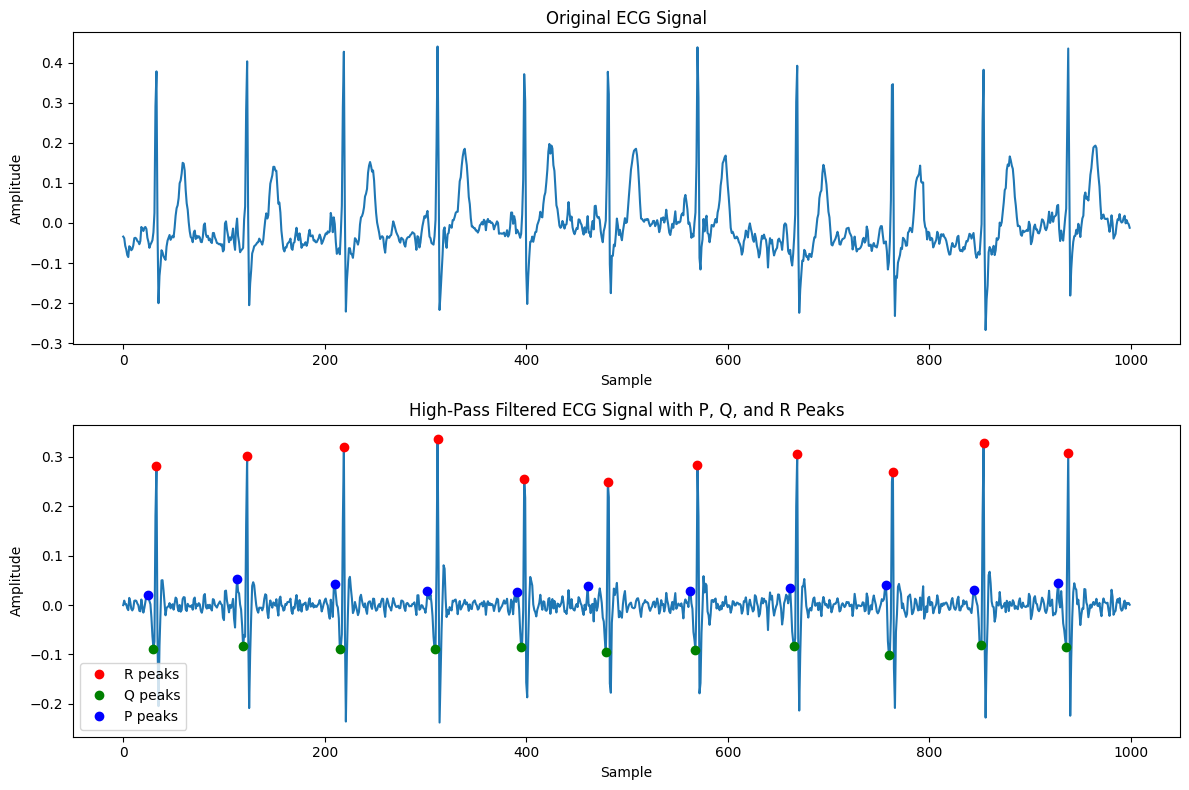

In [10]:
# High-Pass Filter

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# high-pass filter
fs = record.fs  
cutoff = 10 
filtered_signal = butter_highpass_filter(signal, cutoff, fs)

# R peaks
r_peaks, _ = find_peaks(filtered_signal, distance=0.4*fs, prominence=0.3) 

# Q peaks
q_peaks = []
for r_peak in r_peaks:
    window_start = max(0, r_peak - int(0.1*fs))
    window = filtered_signal[window_start:r_peak]
    q_peak = window_start + np.argmin(window)
    q_peaks.append(q_peak)

# P peaks
p_peaks = []
for r_peak in r_peaks:
    window_start = max(0, r_peak - int(0.3*fs))
    window_end = max(0, r_peak - int(0.05*fs))
    window = filtered_signal[window_start:window_end]
    p_peak = window_start + np.argmax(window)
    p_peaks.append(p_peak)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(signal)
plt.title('Original ECG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(filtered_signal)
plt.plot(r_peaks, filtered_signal[r_peaks], 'ro', label='R peaks')
plt.plot(q_peaks, filtered_signal[q_peaks], 'go', label='Q peaks')
plt.plot(p_peaks, filtered_signal[p_peaks], 'bo', label='P peaks')
plt.title('High-Pass Filtered ECG Signal with P, Q, and R Peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

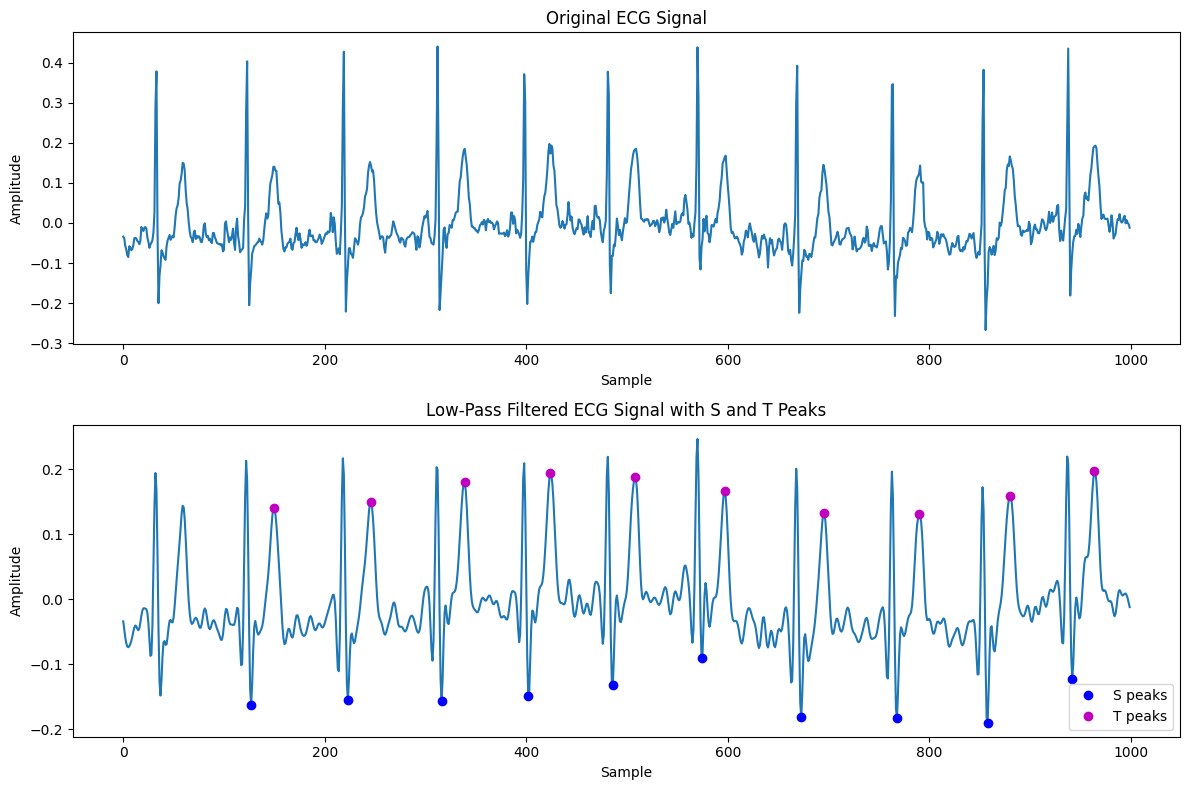

In [4]:
# Low-Pass Filter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Apply low-pass filter
fs = record.fs
cutoff = 15
filtered_signal = butter_lowpass_filter(signal, cutoff, fs)

# R peaks
r_peaks, _ = find_peaks(filtered_signal, distance=0.4*fs, prominence=0.3) 


# S peaks
s_peaks = []
for r_peak in r_peaks:
    window_end = min(len(filtered_signal), r_peak + int(0.15 * fs))
    window = filtered_signal[r_peak:window_end]
    s_peak = r_peak + np.argmin(window)
    s_peaks.append(s_peak)

# T peaks
t_peaks = []
for s_peak in s_peaks:
    window_start = s_peak
    window_end = min(len(filtered_signal), s_peak + int(0.4 * fs))
    window = filtered_signal[window_start:window_end]
    t_peak = window_start + np.argmax(window)
    t_peaks.append(t_peak)


plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(signal)
plt.title('Original ECG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(filtered_signal)
plt.plot(s_peaks, filtered_signal[s_peaks], 'bo', label='S peaks')
plt.plot(t_peaks, filtered_signal[t_peaks], 'mo', label='T peaks')
plt.title('Low-Pass Filtered ECG Signal with S and T Peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()
